In [172]:
from os import path
import glob

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.interpolate import interp1d

from pyia import GaiaData
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
import scipy.stats
import sfd

Combine tables:

In [6]:
# tbls = []
# for fn in glob.glob('../data/gd1-polygon/gd1_ext_*.fits'):
#     tbls.append(Table.read(fn))
# tbl = vstack(tbls)
# tbl.write('../data/gd1-polygon/gd1_all_moar.fits')

---

In [182]:
t = Table.read('../data/gd1-polygon/gd1_all_moar.fits')

c = coord.SkyCoord(ra=t['ra']*u.deg,
                   dec=t['dec']*u.deg)

ext = sfd.reddening(c, survey='PS1', filters='grizy')

# deredden
bands = ['g', 'r', 'i', 'z', 'y']
for i, band in enumerate(bands):
    t[band] = t[band] - ext[:, i]

In [183]:
g = GaiaData(t)

In [184]:
c = g.get_skycoord(distance=False)

In [185]:
gd1 = c.transform_to(gc.GD1)

In [186]:
phi1 = gd1.phi1.wrap_at(180*u.deg).degree
phi2 = gd1.phi2.degree

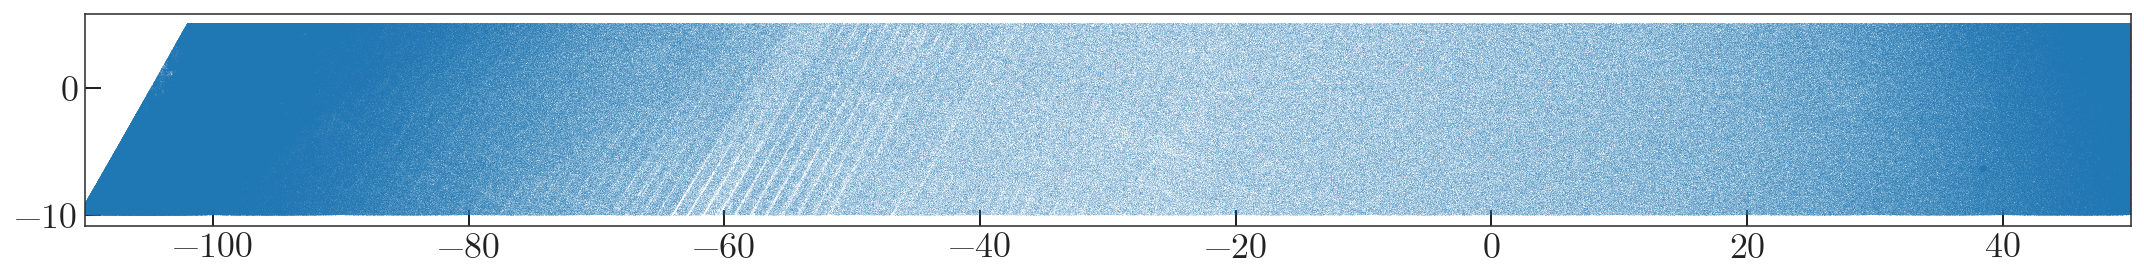

In [187]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(phi1, phi2, marker=',', alpha=0.1, linestyle='none')
ax.set_aspect('equal')
ax.set_xlim(-110, 50)
fig.tight_layout()

Load orbit fit (see `GD1-orbit-fit` notebook):

In [55]:
phi20, d0, pm10, pm20, vr0 = [ -3.47508757,   12.26167261,   -5.70045392,   -1.44728331, -326.96276272]

gc_frame = coord.Galactocentric(galcen_distance=8*u.kpc, z_sun=0*u.pc)
phi10 = 20. * u.deg

c = gc.GD1(phi1=phi10, phi2=phi20*u.deg, distance=d0*u.kpc, 
           pm_phi1_cosphi2=pm10*u.mas/u.yr,
           pm_phi2=pm20*u.mas/u.yr,
           radial_velocity=vr0*u.km/u.s)
w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

In [62]:
ham = gp.Hamiltonian(gp.MilkyWayPotential(nucleus=dict(m=0), 
                                          halo=dict(c=0.95, m=7E11),
                                          bulge=dict(m=4E9),
                                          disk=dict(m=5.5e10)))

orbit0 = ham.integrate_orbit(w0, dt=-0.5*u.Myr, n_steps=100)
fit_orbit = ham.integrate_orbit(orbit0[-1], dt=0.5*u.Myr, n_steps=250)

In [63]:
orbit_c = fit_orbit.to_coord_frame(gc.GD1, galactocentric_frame=gc_frame)

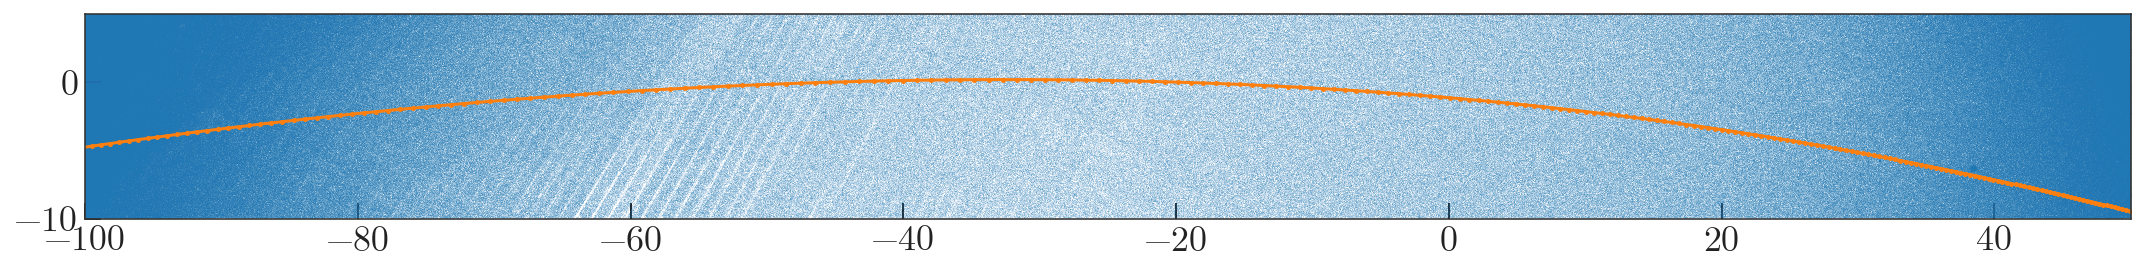

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(phi1, phi2, marker=',', alpha=0.1, linestyle='none')
ax.plot(orbit_c.phi1.wrap_at(180*u.deg).degree,
        orbit_c.phi2.degree)
ax.set_aspect('equal')
ax.set_xlim(-100, 50)
ax.set_ylim(-10, 5)
fig.tight_layout()

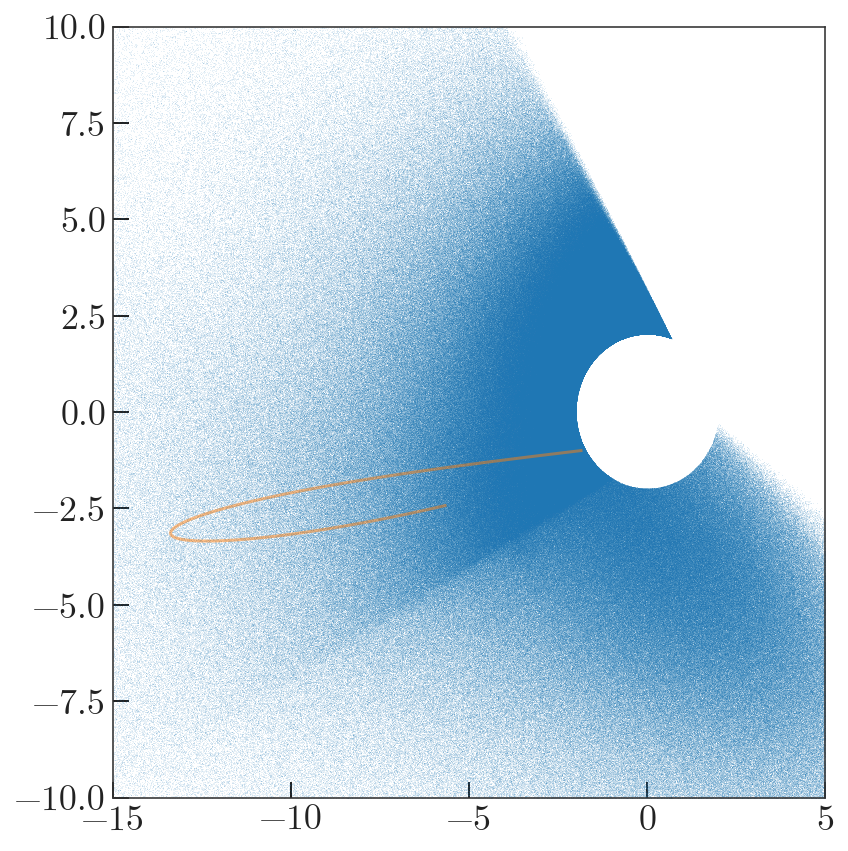

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(gd1.pm_phi1_cosphi2, gd1.pm_phi2, marker=',', linestyle='none', alpha=0.1)
ax.plot(orbit_c.pm_phi1_cosphi2, orbit_c.pm_phi2, marker='', alpha=0.5)
ax.set_xlim(-15, 5)
ax.set_ylim(-10, 10)
fig.tight_layout()

In [119]:
orbit_phi1 = orbit_c.phi1.wrap_at(180*u.deg).degree
orbit_phi2 = orbit_c.phi2.degree

In [127]:
phi2_orb_interp = interp1d(orbit_phi1, orbit_phi2, bounds_error=False)
pm1_orb_interp = interp1d(orbit_phi1, orbit_c.pm_phi1_cosphi2.value, bounds_error=False)
pm2_orb_interp = interp1d(orbit_phi1, orbit_c.pm_phi2.value, bounds_error=False)

In [124]:
track_mask = ((phi2 < (phi2_orb_interp(phi1) + 1)) & (phi2 > (phi2_orb_interp(phi1) - 1.2)) & 
              (phi1 > -100) & (phi1 < 50))

/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


### Start with CMD filtering:

In [74]:
iso = Table.read('../data/mist_12.0_-1.35.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<5)
iso = iso[phasecut]

In [188]:
points_gi = np.array([g.g - g.i, g.g]).T
points_rz = np.array([g.r - g.z, g.r]).T

In [189]:
# fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

all_cmd_mask = np.zeros(len(g)).astype(bool)
all_pm_mask = np.zeros(len(g)).astype(bool)

_bins = np.arange(-110, 50+1, 5)
l_bins = _bins[:-1]
r_bins = _bins[1:]
for j, l, r in zip(range(len(l_bins)), l_bins, r_bins):
    orbit_mask = (orbit_phi1 >= l) & (orbit_phi1 <= r)
    phi1_mask = (phi1 >= l) & (phi1 <= r)
    dm = np.mean(orbit_c.distance[orbit_mask]).distmod.value
    
    # main sequence + rgb
    i_gi = iso['PS_g']-iso['PS_i']
    i_g = iso['PS_g'] + dm
    gi_left = i_gi - 0.4*(i_g/28)**5
    gi_right = i_gi + 0.5*(i_g/28)**5
    
    i_rz = iso['PS_r']-iso['PS_z']
    i_r = iso['PS_r'] + dm
    rz_left = i_rz - 0.4*(i_r/28)**5
    rz_right = i_rz + 0.5*(i_r/28)**5

    poly = np.hstack([np.array([gi_left, i_g]), np.array([gi_right[::-1], i_g[::-1]])]).T
    ind = (poly[:,1]<21.3) & (poly[:,1]>(3+dm))
    poly_main_gi = poly[ind]
    cmd_mask_gi = mpl.path.Path(poly_main_gi).contains_points(points_gi)
    
    poly = np.hstack([np.array([rz_left, i_r]), np.array([rz_right[::-1], i_r[::-1]])]).T
    ind = (poly[:,1]<21.3) & (poly[:,1]>(2+dm))
    poly_main_rz = poly[ind]
    cmd_mask_rz = mpl.path.Path(poly_main_rz).contains_points(points_rz)
    
#     pm = mpl.patches.Polygon(poly_main_gi, color='orange', alpha=0.2, 
#                              zorder=2, label='', linewidth=0)
#     axes[0].add_artist(pm)
    
#     pm = mpl.patches.Polygon(poly_main_rz, color='orange', alpha=0.2, 
#                              zorder=2, label='', linewidth=0)
#     axes[1].add_artist(pm)
        
    # ---
    
    full_mask = track_mask & cmd_mask_gi & cmd_mask_rz & phi1_mask

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(gd1.pm_phi1_cosphi2[full_mask], 
            gd1.pm_phi2[full_mask], 
            marker='.', linestyle='none', alpha=0.2)
    # ax.plot(orbit_c.pm_phi1_cosphi2, orbit_c.pm_phi2, marker='', alpha=0.5)

    pm1 = np.median(pm1_orb_interp(phi1[full_mask]))
    pm2 = np.median(pm2_orb_interp(phi1[full_mask]))
    ax.scatter(pm1, pm2, marker='o', alpha=0.75, color='tab:orange')
    
    pm_mask = np.sqrt((gd1.pm_phi1_cosphi2.value - pm1)**2 + (gd1.pm_phi2.value - pm2)**2) < 1.3
    ax.plot(gd1.pm_phi1_cosphi2[full_mask & pm_mask], 
            gd1.pm_phi2[full_mask & pm_mask], 
            marker='.', color='tab:green',
            linestyle='none', alpha=0.5)

    ax.set_xlim(-15, 5)
    ax.set_ylim(-10, 10)
    ax.set_xlabel('pm1')
    ax.set_ylabel('pm2')
    ax.set_title('{0}–{1}'.format(l, r))
    fig.tight_layout()
    fig.savefig('../plots/cmd-slide/{0:02d}.png'.format(j), dpi=250)
    plt.close(fig)
    
    # ---
    
    all_cmd_mask = all_cmd_mask | (phi1_mask & cmd_mask_gi & cmd_mask_rz)
    all_pm_mask = all_pm_mask | (phi1_mask & pm_mask)

# axes[0].plot(points_gi[:, 0], points_gi[:, 1], marker=',', alpha=0.1, linestyle='none')
# axes[1].plot(points_rz[:, 0], points_rz[:, 1], marker=',', alpha=0.1, linestyle='none')
    
# axes[0].set_xlim(-0.25, 0.75)
# axes[0].set_ylim(21.3, 14)

/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in less
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in greater
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in less
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in greater
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in less


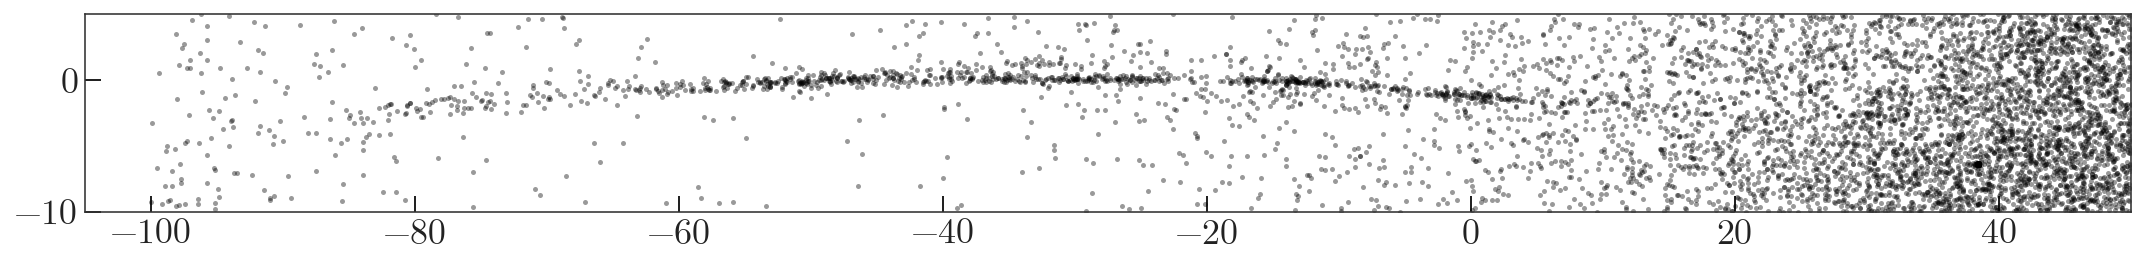

In [190]:
full_mask = all_cmd_mask & all_pm_mask
# full_mask = all_pm_mask
# full_mask = np.ones_like(all_pm_mask).astype(bool)

fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax.plot(phi1[full_mask], phi2[full_mask], 
        marker='.', linewidth=0, alpha=0.4, 
        linestyle='none', color='k')
# ax.plot(orbit_c.phi1.wrap_at(180*u.deg).degree,
#         orbit_c.phi2.degree)

ax.set_aspect('equal')
ax.set_xlim(-105, 50)
ax.set_ylim(-10, 5)
fig.tight_layout()